In [30]:
'''Installation requirements for running code in colab'''
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install gymnasium[mujoco]
!pip install free-mujoco-py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libglew-dev is already the newest version (2.1.0-4).
libgl1-mesa-dev is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
libosmesa6-dev is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
software-properties-common is already the newest version (0.99.9.11).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
patchelf is already the newest version (0.10-2build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import random
import gymnasium as gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

device   = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
class ReplayBuffer():
  def __init__(self, size):
    self.size = size
    self.memory = deque([], maxlen=size)

  def insert(self, *args):
    self.memory.append(tuple(args))

  def sample(self, batch):
    return random.sample(self.memory, batch)

  def __len__(self):
    return len(self.memory)

In [33]:
class RescaleActionWrapper(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        return action

In [34]:
def plot(ep, rewards, timesteps):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('frame %s. reward: %s' % (ep, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.plot(np.arange(1, int(len(rewards)/100)+1)*100, np.mean(np.reshape(rewards, (int(len(rewards)/100), 100)), 1), color='r')
    plt.subplot(122)
    plt.title('frame %s. timesteps: %s' % (ep, np.mean(timesteps[-100:])))
    plt.plot(timesteps)
    plt.plot(np.arange(1, int(len(timesteps)/100)+1)*100, np.mean(np.reshape(timesteps, (int(len(timesteps)/100), 100)), 1), color='r')
    plt.show()

In [35]:
class ValueNetwork(nn.Module):
    def __init__(self, n_states, n_hidden):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(n_states, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, 1)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        return self.linear3(x)
        

In [36]:
class QNetwork(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden):
        super(QNetwork, self).__init__()
        
        self.linear1 = nn.Linear(n_states + n_actions, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, 1)
        
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [37]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_states, n_actions, n_hidden, log_std_min=-10, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(n_states, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        
        self.mean_layer = nn.Linear(n_hidden, n_actions)
        
        self.log_std_layer = nn.Linear(n_hidden, n_actions)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_layer(x)
        log_std = self.log_std_layer(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    # Output learnt policy distribution parameters for training
    def action_distribution(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z_sample      = normal.sample()
        action = torch.tanh(mean+ std*z_sample.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z_sample.to(device)) - torch.log(1 - action.square() + epsilon)
        return action, torch.sum(log_prob, dim=-1,keepdim=True)
        

In [38]:
# Hyperparameters
HIDDEN_SIZE = 256
LR = 3e-4
BUFFER_SIZE = 1000000
LOSS = nn.MSELoss()
GAMMA = 0.99
TAU = 1e-2

In [39]:
# INIT training artefacts
replay_buffer = ReplayBuffer(BUFFER_SIZE)
writer = SummaryWriter("drive/MyDrive/RL/SAC_Walker")
env = gym.make("Humanoid-v4")
env = RescaleActionWrapper(env)

n_hidden = HIDDEN_SIZE
n_states  = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

value_net = ValueNetwork(n_states, n_hidden).to(device)
target_net = ValueNetwork(n_states, n_hidden).to(device)

q_net1 = QNetwork(n_states, n_actions, n_hidden).to(device)
q_net2 = QNetwork(n_states, n_actions, n_hidden).to(device)

policy_net = PolicyNetwork(n_states, n_actions, n_hidden).to(device)

for target_param, param in zip(target_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = LOSS
q_criterion1 = LOSS
q_criterion2 = LOSS

value_optimizer  = optim.Adam(value_net.parameters(), lr=LR)
q_optimizer1 = optim.Adam(q_net1.parameters(), lr=LR)
q_optimizer2 = optim.Adam(q_net2.parameters(), lr=LR)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=LR)


In [40]:
def update(batch_size,gamma,tau):
    # Sample experiences from buffer
    batch = replay_buffer.sample(batch_size)
    state, action, reward, next_state, done = map(np.stack, zip(*batch))

    # Vectorize
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    # Forward pass
    q_value1 = q_net1(state, action)
    q_value2 = q_net2(state, action)
    state_value = value_net(state)
    new_action, log_prob = policy_net.action_distribution(state)
    target_value = target_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    
    
    # Train both the Q networks
    q_value_loss1 = q_criterion1(q_value1, target_q_value.detach())
    q_value_loss2 = q_criterion2(q_value2, target_q_value.detach())

    q_optimizer1.zero_grad()
    q_value_loss1.backward()
    q_optimizer1.step()
    q_optimizer2.zero_grad()
    q_value_loss2.backward()
    q_optimizer2.step()    


    # Train the State value network V
    new_q_value = torch.min(q_net1(state, new_action),q_net2(state, new_action))
    state_value_obj = new_q_value - log_prob
    value_loss = value_criterion(state_value, state_value_obj.detach())
    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()


    # Train the Policy network P
    policy_loss = (log_prob - new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    target_net_state_dict = target_net.state_dict()
    value_net_state_dict = value_net.state_dict()
    

    # Soft parameter update of the target state value network    
    for key in value_net_state_dict:
        target_net_state_dict[key] = value_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
    target_net.load_state_dict(target_net_state_dict)

    running_value_loss.append(value_loss.item())
    running_policy_loss.append(policy_loss.item())
    running_q1_loss.append(q_value_loss1.item())
    running_q2_loss.append(q_value_loss2.item())

In [41]:
# Training loop parameters.
max_epochs  = 5000
max_steps   = 1000
epoch   = 0
rewards     = []
timesteps   = []
batch_size  = 128
best = -1000

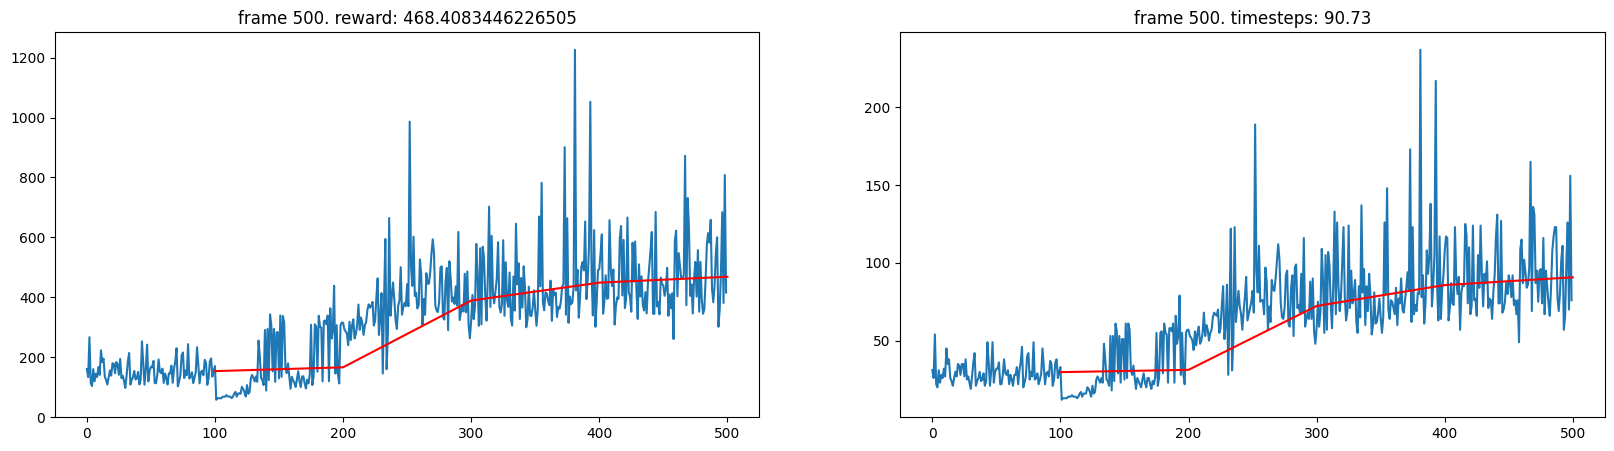

Episode 500: Total reward = 415.71033471281055
Episode 501: Total reward = 805.0609092770604
Episode 502: Total reward = 527.2547518677817
Episode 503: Total reward = 294.19200827678185
Episode 504: Total reward = 522.8740671527949
Episode 505: Total reward = 449.3803861483709
Episode 506: Total reward = 658.1909097157899
Episode 507: Total reward = 698.4947974396046
Episode 508: Total reward = 330.63366644781064
Episode 509: Total reward = 790.3144703837963
Episode 510: Total reward = 746.5309307404917
Episode 511: Total reward = 654.9676731300468
Episode 512: Total reward = 489.59723952698585
Episode 513: Total reward = 415.70115072056643
Episode 514: Total reward = 581.1881891157617
Episode 515: Total reward = 433.5230124941611
Episode 516: Total reward = 514.8174785801929
Episode 517: Total reward = 364.88116973140086
Episode 518: Total reward = 562.358922284731
Episode 519: Total reward = 683.8592596726776
Episode 520: Total reward = 779.2216931917677
Episode 521: Total reward = 3

In [42]:
while epoch < max_epochs:
    state, _ = env.reset()
    episode_reward = 0
    running_policy_loss = []
    running_value_loss = []
    running_q1_loss = []
    running_q2_loss = []
    for step in range(max_steps):
        if epoch > 100:
            with torch.no_grad():
              action, _ = policy_net.action_distribution(torch.tensor(state, dtype=torch.float32).to(device))
            next_state, reward, terminated, truncated, _ = env.step(action.cpu()[0].numpy())
        else:
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, _ = env.step(action)
        
        done = terminated or truncated
        
        replay_buffer.insert(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        
        if len(replay_buffer) > batch_size:
            update(batch_size, GAMMA, TAU)
        
        if done:
            break
        
    writer.add_scalar("Loss/Actor", np.mean(running_policy_loss), epoch)
    writer.add_scalar("Loss/Q1", np.mean(running_q1_loss), epoch)
    writer.add_scalar("Loss/Q2", np.mean(running_q2_loss), epoch)
    writer.add_scalar("Loss/Critic", np.mean(running_value_loss), epoch)
    writer.add_scalar("Rewards/Train", episode_reward, epoch)
    writer.add_scalar("Timesteps/Train", step+1, epoch)
            
    rewards.append(episode_reward)
    timesteps.append(step+1)
    epoch += 1
    if epoch % 100 == 0:
      plot(epoch, rewards, timesteps)

    curr_mean = np.mean(rewards[-100:])
    if curr_mean >= best:
       best = curr_mean
       torch.save(q_net1.state_dict(), 'Walker_SAC_Q_1.h5')
       torch.save(q_net2.state_dict(), 'Walker_SAC_Q_2.h5')
       torch.save(value_net.state_dict(), 'Walker_SAC_value.h5')
       torch.save(target_net.state_dict(), 'Walker_SAC_target.h5')
       torch.save(policy_net.state_dict(), 'Walker_SAC_policy.h5')

    print(f'Episode {epoch}: Total reward = {episode_reward}')
    if curr_mean >= 500:
       print("Solved.")
       break